<a href="https://colab.research.google.com/github/Nayeon0525/study_keras/blob/master/%5BDL%5DMultiinput_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Y형 CNN 생성 & 성능 확인
## 00. Intro
* 데이터: MNIST 데이터 (training, validation, test 영상 수는 교재와 동일) 
* 2개의 branch의 다중입력 사용
* branch 1: 3x3 kernel, 3층의 convLayer
* branch 2: 3x3 kernel, 3층의 convLayer, dilated=2
> **dilated convolution**
> * 일반적으로 3x3 kernel은 receptive field가 3x3이다.   
> * receptive field란 kernel이 한 번에 보는 영역, receptive field가 증가하면 계산량 증가, 정보의 양도 증가 --> 성능은 좋아질 수 있지만 연산량이 증가한다는 단점이 있음.  
> * Pooling을 할 경우 연산량과 함께 정보의 손실도 발생함 --> dilated convolution으로 해결
> * dilation은 receptive field는 증가시키지만 연산량은 그대로
> * ex) dilation factor = 2 & kernel size = 3x3 --> receptive field = 5x5 

* 1개의 branch를 가진 FCN  단일출력


## 01. Load the datasets
* `from keras.datasets import mnist`, `mnist.load_data()`를 통해 mnist datasets를 download한다. 
* train data 60000개, test data 10000개
* 책에서 validation data를 사용하지 않아 임의로 test data에서 5000개씩 나눠 사용했다.


In [1]:
from keras.datasets import mnist

In [2]:
# Downloading data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)

shape of X_train:  (60000, 28, 28)
shape of X_test:  (10000, 28, 28)


## 02. Data Preprocessing

In [4]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]

print("row: ", img_rows)
print("col: ", img_cols)

row:  28
col:  28


In [5]:
# normalization
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [6]:
input_shape = (img_rows, img_cols, 1)
batch_size = 128
num_class = 10
epoch = 10

In [7]:
X_val = X_test[:5000, :, :, :]
X_test = X_test[5000:, :, :, :]

In [8]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [9]:
y_val = y_test[:5000, :]
y_test = y_test[5000:, :]

In [14]:
print("Train) X: {} | y: {}".format(X_train.shape, y_train.shape))
print("Validation) X: {} | y: {}".format(X_val.shape, y_val.shape))
print("Test) X: {} | y: {}".format(X_test.shape, y_test.shape))


Train) X: (60000, 28, 28, 1) | y: (60000, 10)
Validation) X: (5000, 28, 28, 1) | y: (5000, 10)
Test) X: (5000, 28, 28, 1) | y: (5000, 10)


## 03. Constructing the Model

In [15]:
import os
import numpy as np
from keras.layers import *
from keras.models import *

In [16]:
# Input Branch 1
inputs_1 = Input(input_shape)
x = Conv2D(32, 3, activation='relu')(inputs_1)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(64, 3, activation='relu')(x)
#x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Input Branch 2
inputs_2 = Input(input_shape)
w = Conv2D(32, 3, dilation_rate=(2, 2), activation='relu')(inputs_2)
#w = MaxPooling2D((2, 2))(w)
w = Conv2D(64, 3, dilation_rate=(2, 2), activation='relu')(w)
w = MaxPooling2D((2, 2))(w)
w = Dropout(0.2)(w)
w = Conv2D(64, 3, dilation_rate=(2, 2), activation='relu')(w)
w = MaxPooling2D((2, 2))(w)
w = Dropout(0.2)(w)

# Conatenate & Output layer
concat = Concatenate(axis=-1)([x, w])
concat = Flatten()(concat)
concat = Dense(512, activation='relu')(concat)
concat = Dropout(0.5)(concat)
output = Dense(10, activation='softmax')(concat)



In [17]:
model = Model([inputs_1, inputs_2], output)

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

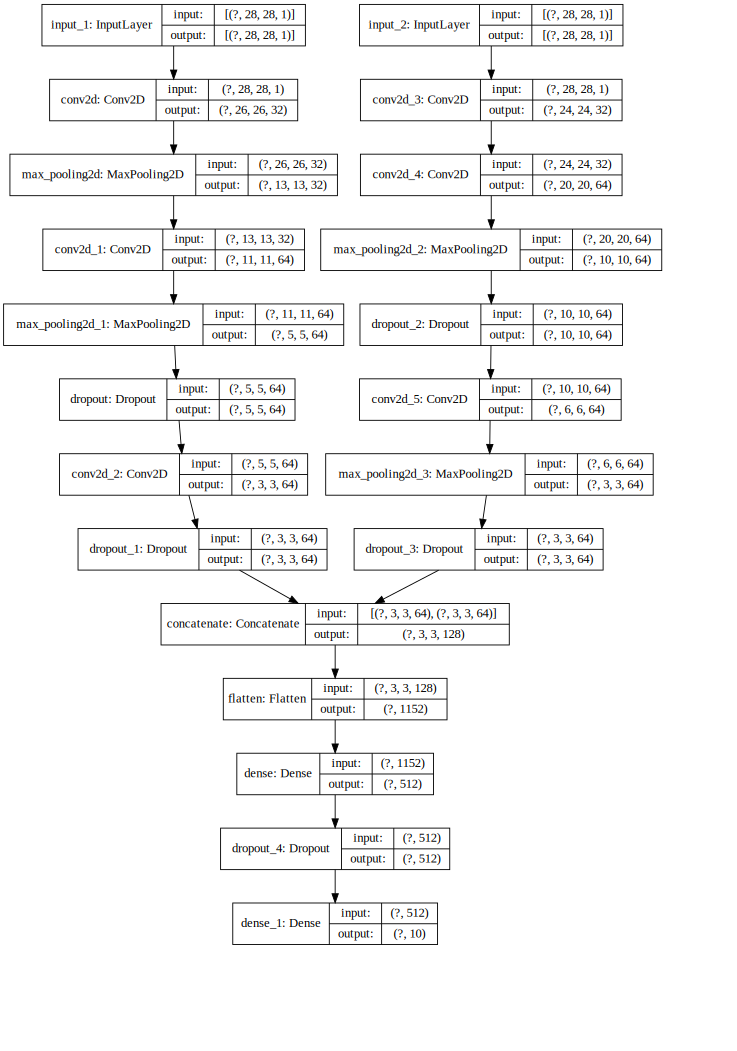

In [20]:
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 24, 24, 32)   320         input_2[0][0]                    
_______________________________________________________________________________________

In [22]:
hist = model.fit([X_train, X_train], y_train,
                 batch_size=batch_size,
                 epochs=epoch,
                 validation_data=([X_val, X_val], y_val))
         

Epoch 1/10
469/469 [==============================] - 14s 30ms/step - loss: 0.2275 - acc: 0.9297 - val_loss: 0.0628 - val_acc: 0.9798
Epoch 2/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0615 - acc: 0.9805 - val_loss: 0.0443 - val_acc: 0.9854
Epoch 3/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0438 - acc: 0.9866 - val_loss: 0.0362 - val_acc: 0.9888
Epoch 4/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0364 - acc: 0.9890 - val_loss: 0.0280 - val_acc: 0.9912
Epoch 5/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0288 - acc: 0.9914 - val_loss: 0.0371 - val_acc: 0.9880
Epoch 6/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0267 - acc: 0.9917 - val_loss: 0.0351 - val_acc: 0.9884
Epoch 7/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0245 - acc: 0.9918 - val_loss: 0.0361 - val_acc: 0.9894
Epoch 8/10
469/469 [==============================] - 14s 29ms

In [25]:
plt.plot?

## 04. Visualizing the Result

In [23]:
import matplotlib.pyplot as plt

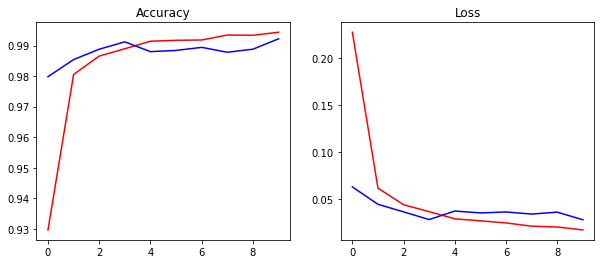

In [41]:
plt.figure(figsize=(10, 4))
# acc
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(hist.history['acc'], 'r-')
plt.plot(hist.history['val_acc'], 'b-')

plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(hist.history['loss'], 'r-')
plt.plot(hist.history['val_loss'], 'b-')

## 05. Testing

In [34]:
score = model.evaluate([X_test, X_test], y_test, verbose=1, batch_size=batch_size)

40/40 [==============================] - 1s 14ms/step - loss: 0.0103 - acc: 0.9966


In [35]:
print("Test Accuracy: ", score[1])
print("Test Loss: ", score[0])

Test Accuracy:  0.9965999722480774
Test Loss:  0.010294266045093536


In [36]:
x_pred = model.predict([X_test, X_test])
y_pred = np.argmax(x_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [37]:
false_res = []

for n in range(0, len(y_true)):
  if y_pred[n] != y_true[n]:
    false_res.append(n)

In [38]:
# 5000개 중 틀린 이미지 총 17개
len(false_res)

17

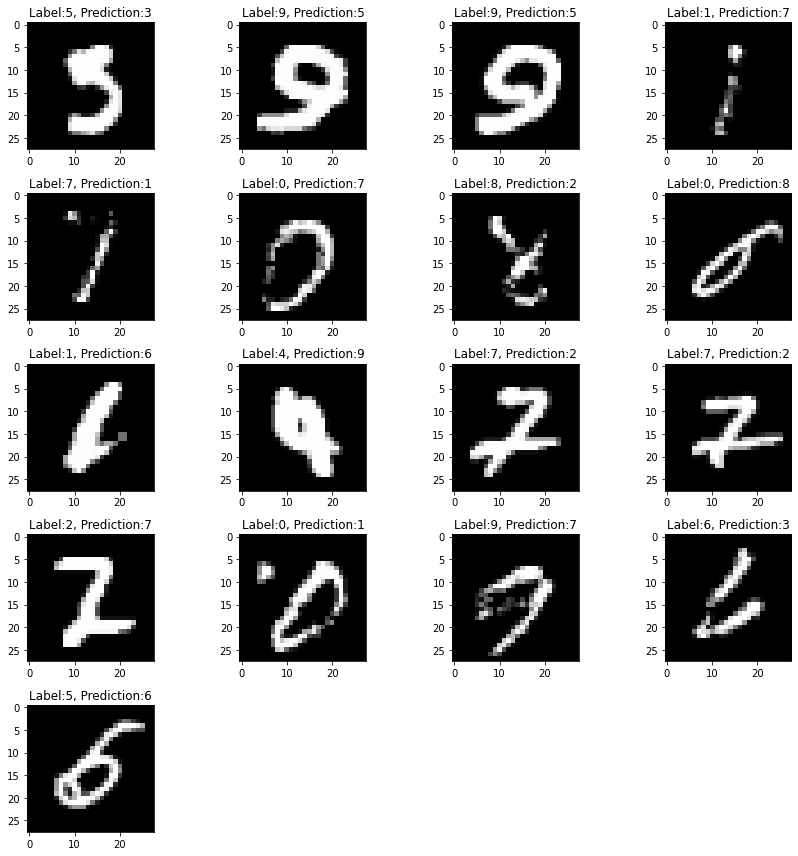

In [40]:
# 틀린 이미지 보기

cnt = 0
nrows = 5
ncols = 4

plt.figure(figsize=(12, 12))

for n in false_res:
  cnt += 1
  plt.subplot(nrows, ncols, cnt)
  plt.imshow(X_test[n].reshape(28, 28), cmap='gray', interpolation='nearest')
  tmp = "Label:" + str(y_true[n]) + ", Prediction:" + str(y_pred[n])
  plt.title(tmp)

plt.tight_layout()
plt.show()